In [1]:
from fastai.vision.all import *
from pathlib import Path
import torch, numpy as np, pandas as pd

# Traffic Sign Recognition

We'll build a traffic sign recognizer/classifier for Belgian traffic signs.  The dataset we'll use is downloaded from [people.ee.ethz.ch](https://people.ee.ethz.ch/~timofter/traffic_signs/). See publication:

@inproceedings{Timofte-BMVC-2011,
author = {Radu Timofte and Luc Van Gool},
title  = {Sparse representation based projections},
booktitle = {British Machine Vision Conference},
year   = {2011},
}

@article{Timofte-MVA-2011,
  author = {Radu Timofte and Karel Zimmermann and Luc {Van Gool}},
  title = {Multi-view Traffic Sign Detection, Recognition, and 3D Localisation},
  journal = {Machine Vision and Applications},
  year = {2011}, 
  doi  = {10.1007/s00138-011-0391-3},
}


In [2]:
# Fetch data from people.ee.ethz.ch
from zipfile import ZipFile
data_path = Path('./traffic-sign')
training_path = untar_data(url='https://people.ee.ethz.ch/~timofter/BelgiumTSC/BelgiumTSC_Training.zip', base=data_path.absolute(), data=data_path.absolute())
testing_path = untar_data(url='http://www.vision.ee.ethz.ch/~timofter/BelgiumTSC/BelgiumTSC_Testing.zip', base=data_path.absolute(), data=data_path.absolute())

## Data Discovery

Let's have a look at one single image from the dataset first, so we know what we're dealing with.

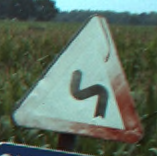

In [3]:
data_path = Path('./traffic-sign')
training_path = Path(data_path/'BelgiumTSC_Training')
testing_path = Path(data_path/'BelgiumTSC_Testing')
img = PILImage.create(training_path/'00006/00147_00000.ppm')
img.to_thumb(400)

In [4]:
training_path.absolute()

Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training')

## Build a quick first model

We'll use FastAI to build a quick first model and see how far we get with that:

In [5]:
fnames = get_image_files(training_path) # gives us something like: [Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00221_00000.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00327_00001.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00326_00001.ppm')]
def label_func(x): return x.parent.name
dls = ImageDataLoaders.from_path_func(training_path.absolute(), fnames, label_func, valid_ptc=0.2, seed=42, item_tfms=Resize(200))
dls.valid_ds.items[:3]

[Path('traffic-sign/BelgiumTSC_Training/00022/00293_00001.ppm'),
 Path('traffic-sign/BelgiumTSC_Training/00032/01824_00000.ppm'),
 Path('traffic-sign/BelgiumTSC_Training/00034/01214_00002.ppm')]

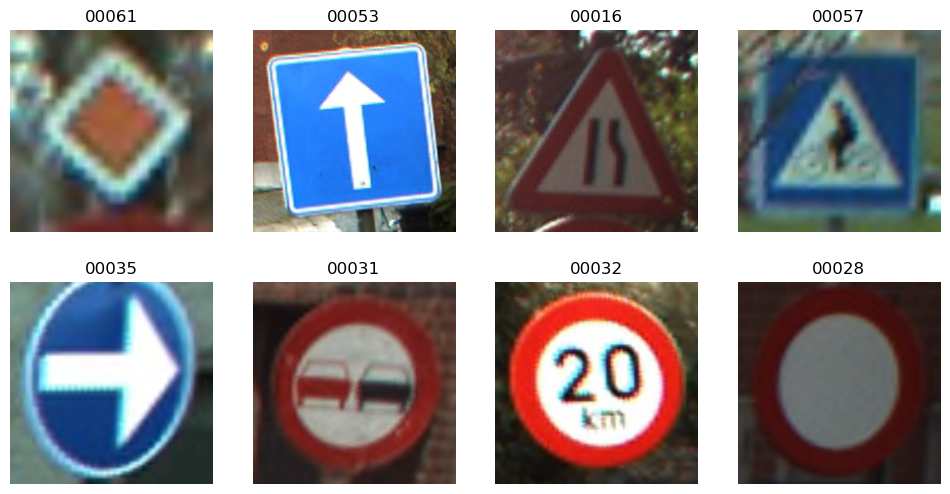

In [6]:
dls.show_batch(nrows=2, ncols=4)

In [7]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/home/xstof/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/xstof/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.727024,0.673027,0.179235,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.533051,0.188462,0.050273,00:16
1,0.260084,0.126643,0.026230,00:15


Let's experiment with using a different learning rate; inspired by the learning rate finder:

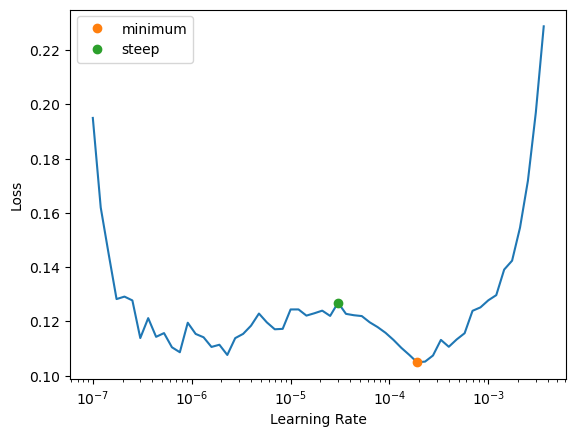

In [8]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [21]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
#learn.fine_tune(9, base_lr=1e-4, freeze_epochs=3)
learn.fine_tune(60, base_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,4.647107,2.163498,0.473224,00:22


epoch,train_loss,valid_loss,error_rate,time
0,2.804215,1.866167,0.407650,00:30
1,2.538824,1.619293,0.355191,00:30
2,2.259410,1.407829,0.314754,00:30
3,2.017063,1.233542,0.283060,00:30
4,1.751366,1.060924,0.245902,00:30
5,1.509648,0.893328,0.210929,00:30
6,1.294406,0.759633,0.184699,00:31
7,1.107021,0.616636,0.146448,00:30
8,0.902775,0.510610,0.122404,00:31
9,0.744051,0.423835,0.099454,00:31


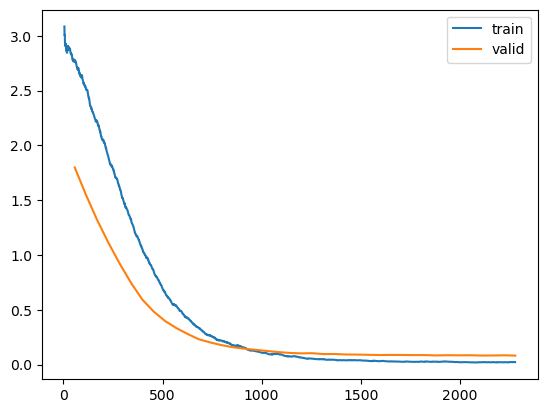

In [19]:
learn.recorder.plot_loss()

What we learn here is that with a slow learning rate and 60 epochs, we're getting down to an error rate of 0.0185 or approximately 2%.  Let's have a look at where those errors are in our data set by looking at a couple of examples.

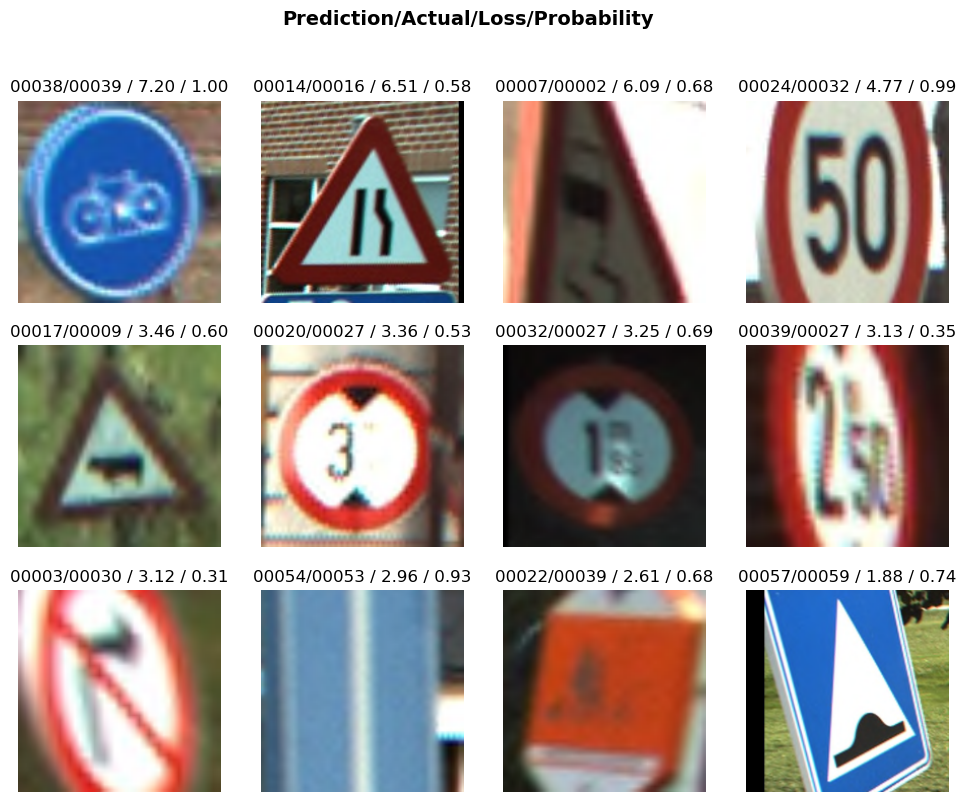

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
# interp.most_confused()
interp.plot_top_losses(12)

In [24]:
learn.lr

0.001

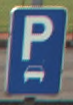

In [16]:
img = PILImage.create(training_path/'00047/00010_00000.ppm')
img.to_thumb(400)

## Data Augmentation

We'll bring more variation in our dataset by augmenting our data now: resizing, skewing etc..